In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import torchvision
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')
print(torch.__version__,device)

batch_size=32
epochs=10

train_dataset=datasets.MNIST(root="./data/MNIST",
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="./data/MNIST",
                            train=False,
                            transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, # minibatch로 나누는 과정
                                        batch_size=batch_size,# 베치 사이즈 크기 결정
                                        shuffle=False)# 데이터 순서를 섞고자 할 때 진행,

1.9.0+cu111 cuda


In [58]:
for (x_train,y_train) in train_loader: # 
  print('x_train:',x_train.size(),'type:',x_train.type())
  print('y_train:',y_train.size(),'type:',y_train.type())
  break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


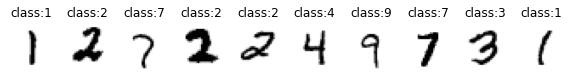

In [59]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28),cmap="gray_r")
  plt.title('class:'+str(y_train[i].item()))

In [60]:
params={'nz':100,'img_size':(784)}
class Generator(nn.Module):
  def __init__(self,params):
    super(Generator,self).__init__()
    self.nz=params['nz']
    self.img_size=params['img_size']
    self.generator=nn.Sequential(
        nn.Linear(self.nz,128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Linear(1024,784),
        nn.Tanh()
    )
  def forward(self,x):
    return self.generator(x)

In [61]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.discriminator=nn.Sequential(
        nn.Linear(784,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    x=x.view(x.size(0),-1)
    return self.discriminator(x)

In [62]:
# He-initializer
import torch.nn.init as init
def weight_init(m):
  if isinstance(m,nn.Linear):
    init.kaiming_uniform_(m.weight.data)
G=Generator(params).to(device)
x=torch.randn(16,100).to(device)
output=G(x)
print(output.shape)

D=Discriminator().to(device)
D.eval()
y=torch.randn(1,784).to(device)
print(D(y).shape)
D.train()
G.train()
D.apply(weight_init)
G.apply(weight_init)

torch.Size([16, 784])
torch.Size([1, 1])


Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [63]:
loss_func=nn.BCELoss()
opt_G=torch.optim.Adam(G.parameters(),lr=0.0001)
opt_D=torch.optim.Adam(D.parameters(),lr=0.0001)

In [1]:
g_loss_graph=[]
d_loss_graph=[]
for epoch in range(100):
  for x_train,y_train in train_loader:
    x_train=x_train.to(device)
    opt_D.zero_grad()
    #real,fake
    y_real=torch.Tensor(32,1).fill_(1.0).to(device)
    y_fake=torch.Tensor(32,1).fill_(0.0).to(device)
    #z
    noise=torch.randn(32,100,device=device)
    #real
    real_outputs=D(x_train)
    d_loss_real=loss_func(real_outputs,y_real)
    real_score=real_outputs
    #fake
    fake_images=G(noise)
    fake_outputs=D(fake_images)
    d_loss_fake=loss_func(fake_outputs,y_fake)
    #loss
    d_loss=(d_loss_real+d_loss_fake)/2
    #역전파
    d_loss.backward()
    opt_D.step()
    #G
    fake_images=G(noise)
    outputs=D(fake_images)
    g_loss=loss_func(outputs,y_real)
    opt_G.zero_grad()
    g_loss.backward()
    opt_G.step()
    g_loss_graph.append(g_loss)
    d_loss_graph.append(d_loss)    
  print("Epoch: %.0f, G_loss: %.6f, D_loss: %.6f"%(epoch,g_loss,d_loss))

NameError: ignored

In [ ]:
def grid_image(tensor_images, size=10, nrow=5):
  tensor_images = ((tensor_images + 1) / 2 ).clamp(0, 1)
  return torchvision.utils.make_grid(tensor_images[:size], nrow=nrow)

def show_image(tensor_images, size=10, nrow=5): # 이미지 출력
  to_pil = transforms.ToPILImage()
  grid_img = grid_image(tensor_images)
  plt.imshow(to_pil(grid_img), interpolation="bicubic")
def rand_z():
   return torch.randn(32, 100).to(device)
z=rand_z()
fake_images=G(z)
show_image(fake_images.view(batch_size, 1, 28, 28))